In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
from scipy import spatial, sparse
import numpy as np
import time
import os

In [2]:
os.chdir('/home/jime/wildfire_GNN')

In [3]:
data = pd.read_csv('~/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

#### making doy relative to year, equal to days since 1/1/1992 now

In [4]:
data['DAY'] = (data['FIRE_YEAR']-1992)*365+data['DISCOVERY_DOY']

#### sort the df

In [5]:
data_unsorted = data
data = data.sort_values(by=['DAY','LATITUDE','LONGITUDE'])

#### only consider rows within the given time range (need to include lat/lon ranges)

need to use cdist for lat/lon

In [100]:
def simpleA(data,day_cts,geo_dist):
    N = data.shape[0]
    A = sparse.lil_matrix((N,N))
    day = data.iloc[0].DAY 
    row_inc=0
    last_day = data.iloc[-1].DAY 
    lat_long = np.array(data[['LATITUDE','LONGITUDE']].values)
    for i in range(N):
        #if the day has changed, reset incrementor
        if data.iloc[i].DAY != day:
            day = data.iloc[i].DAY
            row_inc=0
        #edge case
        if day<(last_day-1):
            tomorrow_index = i-row_inc+day_cts.loc[day]+day_cts.loc[day+1]
        else:
            tomorrow_index = N-1
        #loop over possible entries
        if i<N-1:
            D = spatial.distance.cdist(lat_long[i].reshape(1,-1), lat_long[i+1:tomorrow_index])
            for j in range(len(D[0])):
                if D[0][j]<=geo_dist:
                    A[i,i+j] = 1
                    A[i+j,i] = 1 # this row will fill in entries moving fwd so don't have to check behind
            row_inc+=1
    A = A.tocsr()
    return A

In [101]:
subset = data[data.FIRE_YEAR == 2015][['DAY','LATITUDE','LONGITUDE']]
subset_unsorted = data_unsorted[data_unsorted.FIRE_YEAR == 2015][['DAY','LATITUDE','LONGITUDE']]

Day_Cts = subset.groupby('DAY').agg('count').LATITUDE


In [103]:
subset = data[data.FIRE_YEAR == 2015][['DAY','LATITUDE','LONGITUDE']]
Day_Cts = subset.groupby('DAY').agg('count').LATITUDE

start = time.time()
subset_A = simpleA(subset,Day_Cts,1)
end = time.time()

print(end-start)

47.431896924972534


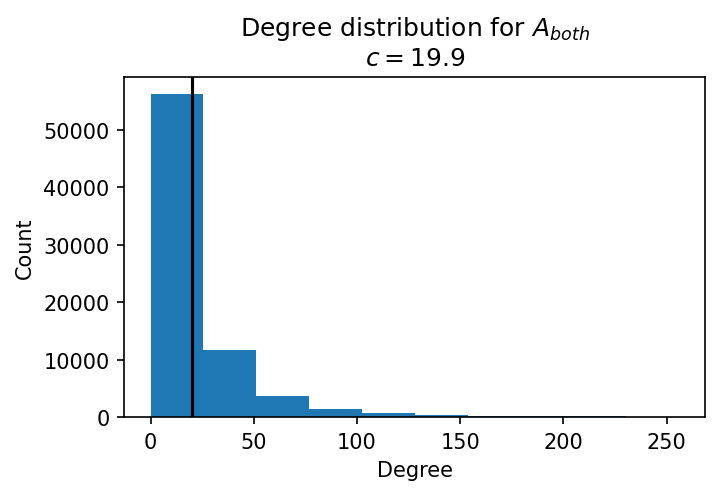

In [105]:
deg = subset_A.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{both}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

#### Save

In [106]:
with open('adj/Aboth_simple.pkl', 'wb') as f:
    pickle.dump(subset_A, f)

#### Load

In [9]:
with open('adj/Aboth_simple.pkl', 'rb') as f:
    subset_A = pickle.load(f)

In [10]:
with open('adj/Aboth.pkl', 'rb') as f:
    old_Aboth = pickle.load(f)

In [109]:
old_Aboth

<74491x74491 sparse matrix of type '<class 'numpy.float64'>'
	with 1247216 stored elements in Compressed Sparse Row format>

In [110]:
subset_A

<74491x74491 sparse matrix of type '<class 'numpy.float64'>'
	with 1484304 stored elements in Compressed Sparse Row format>

# DEBUGGING / comparison of adjacency methods

#### sort old matrix using lexsort

In [55]:
DayArr = np.array(subset_unsorted.DAY)
LatArr = np.array(subset_unsorted.LATITUDE)
LonArr = np.array(subset_unsorted.LONGITUDE)

ind = np.lexsort((LonArr,LatArr,DayArr))
old_Aboth_sorted = []
for i in ind:
    old_Aboth_sorted.append(old_Aboth[i])

#### show they are the same ordering now

In [84]:
print(subset_unsorted.iloc[ind].head())
print(subset.head())

DAY   LATITUDE   LONGITUDE  ADJ
61842  8396  29.476678  -95.806274    0
44037  8396  30.283818  -96.278915    0
63759  8396  32.180400 -110.848400    0
63756  8396  32.180500 -110.848300    0
63757  8396  32.180600 -110.848200    0
        DAY   LATITUDE   LONGITUDE
61842  8396  29.476678  -95.806274
44037  8396  30.283818  -96.278915
63759  8396  32.180400 -110.848400
63756  8396  32.180500 -110.848300
63757  8396  32.180600 -110.848200


#### compare a few points

In [107]:
for index in range(100,110):
    row_old = old_Aboth_sorted[index].todense().tolist()[0]
    row_new = subset_A[index].todense().tolist()[0]

    #print indices
    print("point:")
    print("_____________________________\n")
    print(subset.iloc[index])
    print("\noriginal A:")
    print("_____________________________\n")
    print([subset_unsorted.iloc[ind] for ind,x in enumerate(row_old) if x == 1])
    print("\nnew A:")
    print("_____________________________\n")
    print([subset.iloc[ind] for ind,x in enumerate(row_new) if x == 1])
    print("_____________________________\n\n\n")

point:
_____________________________

DAY          8398.000000
LATITUDE       30.596567
LONGITUDE     -93.915228
Name: 18988, dtype: float64

original A:
_____________________________

[DAY          8398.000000
LATITUDE       30.596567
LONGITUDE     -93.915228
Name: 18988, dtype: float64]

new A:
_____________________________

[]
_____________________________



point:
_____________________________

DAY          8398.000000
LATITUDE       31.589854
LONGITUDE     -94.870806
Name: 42945, dtype: float64

original A:
_____________________________

[DAY          8398.000000
LATITUDE       31.589854
LONGITUDE     -94.870806
Name: 42945, dtype: float64]

new A:
_____________________________

[]
_____________________________



point:
_____________________________

DAY          8398.000000
LATITUDE       31.754153
LONGITUDE    -103.144798
Name: 20727, dtype: float64

original A:
_____________________________

[DAY          8398.000000
LATITUDE       31.754153
LONGITUDE    -103.144798
Name: 207

#### Manual checking bc confusion ensues

In [99]:
spatial.distance.cdist([[31.95889,-97.303005]],[[32.483669,-98.037552]])

array([[0.90274708]])